2022-07-08 19:11:29,149 [INFO] ** TORCH CUDA version installed and working. **
2022-07-08 19:11:29,150 [INFO] >>>> using GPU
2022-07-08 19:11:29,723 [INFO] Global seed set to 1337
2022-07-08 19:11:29,850 [INFO] Loading imagenet weights


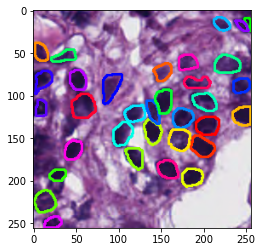

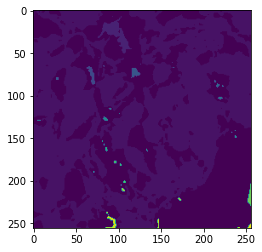

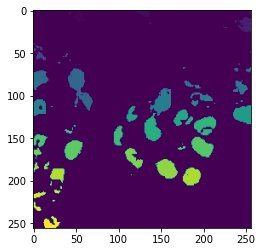

2022-07-08 19:11:31,207 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2022-07-08 19:11:32,340 [WARNING] WARNING: not interp
2022-07-08 19:11:32,493 [INFO] estimated cell diameter(s) in 1.29 sec
2022-07-08 19:11:32,494 [INFO] >>> diameter(s) = 
2022-07-08 19:11:32,495 [INFO] [ 31.03 ]
2022-07-08 19:11:32,495 [INFO] ~~~ FINDING MASKS ~~~
2022-07-08 19:11:33,417 [INFO] >>>> TOTAL TIME 2.21 sec


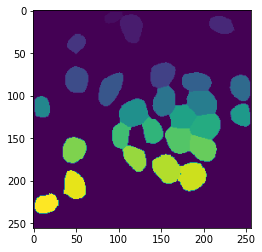

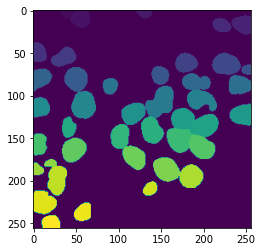

In [24]:
# look up
# DERMA
# 0.04: /home/ws/sc1357/data/$RESULT_DIR/20220708_1426_0006_dnn_model.tar
# 0.08: /home/ws/sc1357/data/$RESULT_DIR/20220708_1425_0007_dnn_model.tar
# 0.16: /home/ws/sc1357/data/$RESULT_DIR/20220708_1426_0004_dnn_model.tar
# 0.32: /home/ws/sc1357/data/$RESULT_DIR/20220708_1427_0005_dnn_model.tar


from DLIP.utils.visualization.inst_seg_contour import visualize_instances_map
import tifffile
from skimage.io import imread, imsave    
import numpy as np
import matplotlib.pyplot as plt
from DLIP.utils.metrics.inst_seg_metrics import remap_label, get_fast_aji_plus
import cv2 
from skimage.color import label2rgb

class StatusBar:
    def __init__(self, ):
        pass
    def showMessage(self, msg):
        pass

img = tifffile.imread('/home/ws/sc1357/data/datasets/2018_MoNuSeg_cropped/test/samples/TCGA-2Z-A9J9-01A-01-TS1.tif')[0:255,0:255,:]
label = tifffile.imread('/home/ws/sc1357/data/datasets/2018_MoNuSeg_cropped/test/labels/TCGA-2Z-A9J9-01A-01-TS1.tif').squeeze()[0:255,0:255]
# img =  imread('/home/ws/sc1357/data/datasets/2017_ISIC_Derma/test/samples/ISIC_0014077.jpg')
# label = (imread('/home/ws/sc1357/data/datasets/2017_ISIC_Derma/test/labels/ISIC_0014077_segmentation.png').squeeze()>0).astype(np.uint8)
pre_anno_lst = []

PREFIX = "monuseg_sphero_2"

img = cv2.resize(img, (256,256), interpolation=cv2.INTER_NEAREST)
label = cv2.resize(label, (256,256), interpolation=cv2.INTER_NEAREST)

from DLIP.pre_labeling.instance_segmentation.pre_labeler_otsu_inst import PreLabelerOtsuInst
from DLIP.pre_labeling.instance_segmentation.pre_labeler_percentile_inst import PreLabelerPercentileInst
from DLIP.pre_labeling.instance_segmentation.pre_labeler_unet_inst import UnetInstancePreLabeler
from DLIP.pre_labeling.instance_segmentation.pre_labeler_cellpose import Cellpose

pre_anno_lst.append(PreLabelerOtsuInst(do_closing=False, inverse=True))
pre_anno_lst.append(PreLabelerPercentileInst(10, inverse=True))
pre_anno_lst.append(Cellpose(model_type="cyto", use_gpu=True))
pre_anno_lst.append(UnetInstancePreLabeler("/home/ws/sc1357/data/$RESULT_DIR/20220708_1427_0005_dnn_model.tar"))

imsave(f"{PREFIX}_org.png", img)

plt.imshow(label)
plt.show()


overlay = visualize_instances_map(img,label, line_thickness=2)
imsave(f"{PREFIX}_gt.png", overlay)
plt.imshow(overlay)
plt.show()

for method in pre_anno_lst:
    pre_anno = method.predict(img, StatusBar())
    aji = get_fast_aji_plus(remap_label(label), remap_label(pre_anno))
    
    overlay = visualize_instances_map(img,pre_anno, line_thickness=2)
    imsave(f"{PREFIX}_{method.__class__.__name__}_AJI_{str(aji).replace('.', 'p')}.png", overlay)
    plt.imshow(pre_anno)
    plt.show()


